# EPFL BIO 322 Project  
### Gene Prediction based on Mouse brain single cell gene expression profiles

### Authors:

- Simon Lee (simon.lee@epfl.ch) 
- Léa Goffinet (lea.goffinet@epfl.ch)

## Project Description

In an experiment on epigenetics and memory, Giulia Santoni (from the lab of Johannes Gräff at
EPFL) measured the gene expression levels in multiple cells of a mouse brain under three different
conditions that we call KAT5, CBP and eGFP. In this challenge, the goal is to predict – as accurately
as possible – for each cell the experimental condition (KAT5, CBP or eGFP) under which it was
measured, given only the gene expression levels.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell

from tqdm import tqdm
import requests
import os
import sys
from pathlib import Path
import multiprocessing as mp
from multiprocessing import Process
import concurrent
from multiprocessing import Pool
import xgboost as xgb
import glob

InteractiveShell.ast_node_interactivity = "all"

### Data Preprocessing and visualisation

This section covers the loading, filtering and visualisation of the data.

In [2]:
# read raw data
df = pd.read_csv('../data/train.csv.gz', compression='gzip')
df

,Xkr4,Gm1992,Gm19938,Gm37381,Rp1,Sox17,Gm37587,Gm37323,Mrpl15,Lypla1,...,AC163611.1,AC163611.2,AC140365.1,AC124606.2,AC124606.1,AC133095.2,AC133095.1,AC234645.1,AC149090.1,labels
0,2.190380,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.293686,CBP
1,2.861984,0.0,0.506726,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.506726,KAT5
2,2.766762,0.0,0.629614,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.683511,eGFP
3,2.146434,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.432486,CBP
4,2.840049,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.164235,eGFP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.108581,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.312030,KAT5
4996,3.108972,0.0,0.783343,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.518711,eGFP
4997,2.025946,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.025946,CBP
4998,1.227544,0.0,0.791370,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,KAT5


As expected single cell data is extremely sparse. Lets count to see how many non zero entries we actually have per column to get a glimpse of what might be important genes and what might not be important.

In [3]:
gene_column_headers = df.columns.values.tolist()

run this cell only if you want to do filter and write out the counts of how many non zero columns are in each column to a txt file

In [4]:
# # this gets the counts of each column and drops the column accordingly
# f = open('../data/counts.txt', 'w')
# for gene in gene_column_headers:
#     count = (df[gene] != 0).sum()
    
#     f.write('Counts of gene in cells {} : {} \n'.format(gene, count))  # Uncomment if you want to generate text file with counts

#     # new data generator: Takes 3 hrs to run!!
#     # if count < 500:
#     #     df = df.drop(columns=[gene])

# # df.to_csv('../data/filtered_train.csv.gz, compression='gzip')

# f.close()

In [5]:
df_filtered = pd.read_csv('../data/filtered_train.csv.gz')

We can see that the filtering process removed over 22,000 genes that were seen across less than 10% of the cells. Though the threshold is a hyperparameter we believe choosing a smaller hyperparameter will be a safer bet to not throw away useful information

In [6]:
df_filtered

,Unnamed: 0,Xkr4,Gm19938,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,Pcmtd1,...,mt-Co3,mt-Nd3,mt-Nd4,mt-Nd5,mt-Cytb,CAAA01118383.1,Vamp7,Tmlhe,AC149090.1,labels
0,0,2.190380,0.000000,0.0,0.000000,1.293686,0.000000,1.839343,1.839343,2.190380,...,2.190380,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.293686,CBP
1,1,2.861984,0.506726,0.0,0.000000,0.506726,1.458439,1.291817,1.091771,0.841436,...,0.000000,0.00000,0.000000,0.000000,0.506726,0.000000,0.0,0.000000,0.506726,KAT5
2,2,2.766762,0.629614,0.0,0.000000,1.012971,0.629614,0.629614,0.000000,1.012971,...,0.000000,0.00000,0.000000,0.000000,0.629614,0.000000,0.0,0.000000,1.683511,eGFP
3,3,2.146434,0.000000,0.0,0.000000,0.000000,0.000000,1.060763,0.000000,1.060763,...,0.664895,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.432486,CBP
4,4,2.840049,0.000000,0.0,0.000000,0.000000,1.132100,0.531053,0.000000,1.649491,...,0.531053,0.00000,0.000000,0.000000,0.000000,0.531053,0.0,0.000000,2.164235,eGFP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,2.108581,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.644255,0.644255,...,1.312030,0.00000,0.000000,0.000000,1.032877,0.000000,0.0,0.000000,1.312030,KAT5
4996,4996,3.108972,0.783343,0.0,0.000000,0.000000,0.783343,0.783343,0.466491,1.379256,...,0.466491,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.466491,1.518711,eGFP
4997,4997,2.025946,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.386459,0.000000,...,2.650884,0.00000,2.386459,1.456669,1.456669,0.000000,0.0,1.456669,2.025946,CBP
4998,4998,1.227544,0.791370,0.0,0.000000,0.791370,0.000000,0.791370,0.791370,0.791370,...,2.245478,0.79137,1.227544,0.000000,2.108819,0.000000,0.0,0.000000,0.000000,KAT5


In [7]:
df_filtered = df_filtered.drop(columns='Unnamed: 0')

In [8]:
#check for any null values incase we need to perform imputation
check_nan = df.isnull().values.any()
print(check_nan)

False


In [9]:
gene_column_headers = df_filtered.columns.values.tolist()

We're performing PCA, once with the whole data and once with the filtered data, to see if there is different clusters but also to make sure that the filtered data is corresponding to the raw data.

In [10]:
from sklearn.preprocessing import StandardScaler

x = df.iloc[:, :-1].values
y = df.loc[:,['labels']].values

x = StandardScaler().fit_transform(x)

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
df_pca = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [12]:
pca.explained_variance_ratio_

array([0.00808732, 0.00516874])

In [13]:
df_pca_final = pd.concat([df_pca, df[['labels']]], axis = 1)

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

Text(0.5, 0, 'Principal Component 1')

Text(0, 0.5, 'Principal Component 2')

Text(0.5, 1.0, 'PCA : 2 components')

<Figure size 432x288 with 0 Axes>

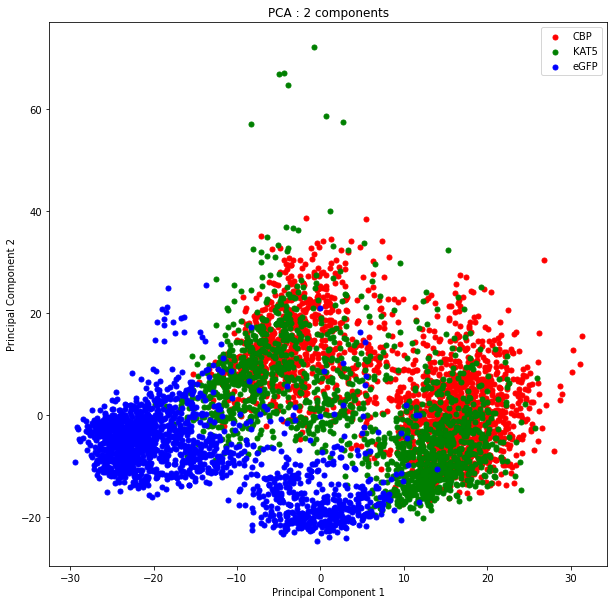

In [14]:
plt.figure()
plt.figure(figsize=(10,10))

labels = ['CBP', 'KAT5', 'eGFP']
colors = ['r', 'g', 'b']
for label, color in zip(labels,colors):
    indicesToKeep = df_pca_final['labels'] == label
    plt.scatter(df_pca_final.loc[indicesToKeep, 'principal component 1'], df_pca_final.loc[indicesToKeep, 'principal component 2'], c = color, s = 25)
plt.legend(labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA : 2 components')
plt.show()

In [15]:
pca.explained_variance_ratio_
#very low explained variance with 2 components...

array([0.00808732, 0.00516874])

In [16]:
#same with df_filtered

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

Text(0.5, 0, 'Principal Component 1')

Text(0, 0.5, 'Principal Component 2')

Text(0.5, 1.0, 'PCA : 2 components')

<Figure size 432x288 with 0 Axes>

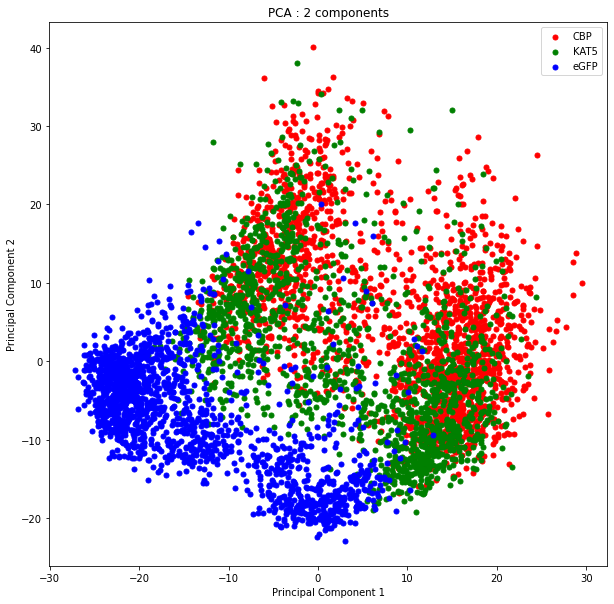

In [17]:
x = df_filtered.iloc[:, :-1].values
y = df_filtered.loc[:,['labels']].values

x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
df_pca = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

df_pca_final = pd.concat([df_pca, df[['labels']]], axis = 1)

plt.figure()
plt.figure(figsize=(10,10))

labels = ['CBP', 'KAT5', 'eGFP']
colors = ['r', 'g', 'b']
for label, color in zip(labels,colors):
    indicesToKeep = df_pca_final['labels'] == label
    plt.scatter(df_pca_final.loc[indicesToKeep, 'principal component 1'], df_pca_final.loc[indicesToKeep, 'principal component 2'], c = color, s = 25)
plt.legend(labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA : 2 components')
plt.show()

### Method 1 : Multinomial Logistic Regression

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [19]:
X = df_filtered.iloc[:,:-1].values
y = df_filtered['labels'].values

X = StandardScaler().fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [20]:
X_train.shape, y_test.shape

((4000, 9137), (1000,))

In [24]:

classifier = LogisticRegression(multi_class='multinomial',solver ='saga')
classifier.fit(X_train, y_train) 

/Users/leagoffinet/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(multi_class='multinomial', solver='saga')

In [25]:
y_pred = classifier.predict(X_test)

In [26]:
cm = confusion_matrix(y_test, y_pred)


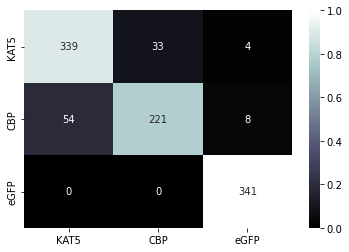

In [27]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

plot_confusion_matrix(cm, ['KAT5', 'CBP', 'eGFP'])

In [28]:
classifier.score(X_test, y_test)

0.901

### Method 2 : Multiple linear regression with L1 regularization

In [ ]:
#mmmmm Logistic is so good, I'm not sure it's worth it to let multiple linear regression, ?

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso

In [47]:
X = df_filtered.iloc[:,:-1]
y = df_filtered['labels']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
  
# Splitting the data into training and testing data
model = LinearRegression()
  
model.fit(X_train,y_train)
print(model.score(X_test, y_test))

LinearRegression()

0.7385210024089912


In [49]:
y_pred = model.predict(X_test)

In [41]:
#y_test

In [42]:
#cm = confusion_matrix(y_test, y_pred)
#plot_confusion_matrix(cm, ['KAT5', 'CBP', 'eGFP'])

In [50]:
X_train

,Xkr4,Gm19938,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,Pcmtd1,Gm26901,...,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4,mt-Nd5,mt-Cytb,CAAA01118383.1,Vamp7,Tmlhe,AC149090.1
1554,2.422675,0.903407,0.0,0.000000,1.163775,1.687138,1.370164,0.000000,1.927454,0.550430,...,0.550430,0.903407,0.000000,0.550430,0.000000,0.550430,0.550430,0.000000,0.000000,1.814498
3689,1.996102,0.000000,0.0,0.000000,0.951688,1.996102,0.951688,0.000000,1.996102,0.000000,...,1.752713,2.827360,0.951688,2.191697,0.951688,1.752713,0.000000,0.000000,0.000000,1.430349
1493,3.129821,0.647755,0.0,0.000000,0.375434,0.000000,1.317409,0.647755,1.187268,0.000000,...,0.000000,0.000000,0.000000,0.375434,0.000000,0.000000,0.000000,0.647755,0.000000,1.432547
2060,2.331880,0.000000,0.0,0.000000,0.573673,0.000000,0.573673,0.935916,1.583888,0.573673,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.573673,0.000000
547,2.319866,0.000000,0.0,0.000000,0.000000,0.000000,1.720470,2.064421,1.191975,1.191975,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.720470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,3.389573,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.099651,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.099651,0.000000,0.000000,0.000000,0.000000,0.000000,3.113069
4269,2.673630,0.418014,0.0,0.418014,0.418014,0.938766,1.123554,1.123554,1.735272,0.711911,...,0.418014,0.000000,0.000000,0.711911,0.000000,0.418014,0.000000,0.418014,0.000000,1.533116
767,2.516502,0.000000,0.0,0.000000,0.000000,1.567588,0.000000,1.567588,0.000000,1.567588,...,0.000000,0.000000,0.000000,1.567588,0.000000,1.567588,0.000000,0.000000,0.000000,2.150614
1030,0.000000,0.000000,0.0,0.000000,0.000000,1.857827,0.000000,0.000000,1.857827,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.855456,0.000000,0.000000,2.675835


In [63]:
coeffs = pd.DataFrame()
coeffs['gene'] = X_train.columns
coeffs['coeffcient'] = pd.Series(model.coef_)
coeffs.tail()

,gene,coeffcient
9132,mt-Cytb,0.006682
9133,CAAA01118383.1,0.015046
9134,Vamp7,0.000784
9135,Tmlhe,0.008704
9136,AC149090.1,0.041721


In [56]:
mean_squared_error_ridge = np.mean((y_pred - y_test)**2)
print(mean_squared_error_ridge)

0.17947892246747094


In [58]:
lasso = Lasso(alpha = 1)
lasso.fit(X_train, y_train)
y_pred1 = lasso.predict(X_test)

Lasso(alpha=1)

In [59]:
mean_squared_error = np.mean((y_pred1 - y_test)**2)
print("Mean squared error on test set", mean_squared_error)

Mean squared error on test set 0.6864005625


In [62]:
lasso_coeff = pd.DataFrame()
lasso_coeff['gene_column_headers'] = X_train.columns
lasso_coeff['coefficient'] = pd.Series(lasso.coef_)
 
lasso_coeff.head()

,gene_column_headers,coefficient
0,Xkr4,0.0
1,Gm19938,0.0
2,Mrpl15,-0.0
3,Lypla1,0.0
4,Tcea1,0.0


## Method 3 XGBoost

- Once with our filtered data
- Also run with raw data to see if filtering has an effect

In [64]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [65]:
# split into train and validation set using sklearn
gene_column_headers_filtered = gene_column_headers[:-1]
y = df_filtered['labels']
X = df_filtered.iloc[:,:-1]

# need to transform our labels from [KAT5, CBP, eGFP] -> [0,1,2] 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [66]:
# perform a typical split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify = y)

training_data = {'X_train':X_train,'y_train':y_train,
                'X_test': X_val,'y_test':y_val}

In [67]:
X_train.shape

(4000, 9137)

In [68]:
y_train.shape

(4000,)

In [69]:
# fit function where it takes the sklearn and xgboost models and performs the boosted trees.
# plots performance and accuracy as well

def fit(model, training_data=training_data, epochs=300, label_gene = gene_column_headers_filtered):
    # fitting to the sklearn model
    print('Fitting model...')
    model.fit(training_data['X_train'], training_data['y_train'])
    print('Fitting done!')

    # fitting the xboost library model
    train = xgb.DMatrix(training_data['X_train'], label=training_data['y_train'])
    test = xgb.DMatrix(training_data['X_test'], label=training_data['y_test'])
    params = model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    evaluation = {}
    evallist = [(test, 'test'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist, evals_result=evaluation,verbose_eval=100)

    # Model reports
    print('-- Model Report --')
    print('XGBoost Accuracy: '+str(accuracy_score(model.predict(training_data['X_test']), training_data['y_test'])))
    print('XGBoost F1-Score: '+str(f1_score(model.predict(training_data['X_test']),training_data['y_test'], average='micro')))
    
    # plotting the error curves for our loss functions
    for m in metrics:
        test_score = evaluation['test'][m]
        train_score = evaluation['train'][m]
        x = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(x, test_score, label="Test")
        plt.plot(x, train_score, label="Train")
        
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Epoch')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
    
    # makes sure that the two array match so we can plot the feature importance
    print("length of features list: {}".format(len(gene_column_headers_filtered)))
    print("length of feature importance vector {}".format(len(model.feature_importances_)))

    return xgb_model

In [70]:
training_data['X_test']

,Xkr4,Gm19938,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,Pcmtd1,Gm26901,...,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4,mt-Nd5,mt-Cytb,CAAA01118383.1,Vamp7,Tmlhe,AC149090.1
448,2.753780,0.434709,0.000000,0.000000,1.314414,0.000000,1.314414,1.571029,0.434709,0.000000,...,1.450931,1.314414,0.736699,0.736699,0.434709,0.736699,0.000000,0.0,0.434709,1.571029
205,2.769547,0.000000,0.000000,0.000000,0.000000,0.000000,1.789056,0.000000,1.250446,0.000000,...,1.250446,1.250446,0.000000,0.000000,1.250446,1.789056,0.000000,0.0,0.000000,0.000000
1572,2.613316,0.000000,0.000000,0.000000,0.582363,0.947994,0.582363,0.582363,1.747735,0.000000,...,0.947994,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.947994
4823,2.665872,0.000000,0.000000,0.670773,0.000000,0.000000,1.068668,0.670773,1.068668,0.670773,...,1.068668,1.068668,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.573395
2924,3.138023,0.588962,0.000000,0.337228,0.789900,0.588962,0.337228,0.789900,0.789900,0.000000,...,0.337228,0.588962,0.000000,0.337228,0.000000,0.588962,0.337228,0.0,0.337228,0.789900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707,0.000000,0.000000,1.022448,0.000000,0.000000,3.550188,0.000000,1.022448,1.846875,0.000000,...,0.000000,1.022448,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2490,2.200992,0.000000,0.000000,0.000000,0.764402,0.764402,0.000000,1.491359,0.764402,0.000000,...,1.721130,1.721130,0.764402,0.764402,0.000000,1.192534,0.000000,0.0,0.000000,1.721130
1935,2.596745,0.000000,0.670586,0.000000,0.670586,0.670586,0.000000,1.068417,1.068417,0.000000,...,1.573092,1.068417,1.068417,1.068417,1.068417,1.573092,0.000000,0.0,0.000000,2.356489
3967,2.377751,0.000000,0.000000,0.000000,1.333544,0.000000,0.874315,0.874315,0.000000,0.000000,...,0.000000,0.874315,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.647061


In [71]:
# hyperparameters that can be adjusted in the final model
xgb_model = XGBClassifier(learning_rate=0.1, # play around with learning rate
                    n_estimators=300, # play around with number of boosted trees built
                    max_depth=9, # play around with tree depth
                    objective='multi:softmax',  # I saw that using softmax or softprob is best for multi class classification
                    nthread=4,
                    num_class=3,
                    seed=1 # seed is included for reproducibility
                    )

xgb_trained = fit(xgb_model, training_data)

Fitting model...


read in test.csv.gz to assess model and predictions

In [ ]:
test = pd.read_csv('../data/test.csv.gz', compression='gzip', usecols=gene_column_headers_filtered)
test

In [ ]:
# get it into dmatrix again
X = test
testing_data = xgb.DMatrix(data=X)

In [ ]:
test = xgb.DMatrix(training_data['X_test'], label=training_data['y_test'])
pred = xgb_trained.predict(test)

In [ ]:
print(classification_report(training_data['y_test'], pred))

In [ ]:
confusion_matrix = confusion_matrix(training_data['y_test'], pred)

In [ ]:
import graphviz
plt.rcParams["figure.figsize"] = [22,40]
xgb.plot_tree(xgb_trained)

In [ ]:
plt.rcParams["figure.figsize"] = [22,22]
xgb.plot_importance(xgb_trained)

as expected alot of features aren't very important but lets still try running our classifier with our raw data 

Raw data. Assess performance

In [ ]:
# split into train and validation set using sklearn
y = df['labels']
X = df.loc[:, df.columns != 'labels'] 

# need to transform our labels from [KAT5, CBP, eGFP] -> [0,1,2] 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# perform a typical split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

data = {'X_train':X_train,'y_train':y_train,
                'X_test': X_val,'y_test':y_val}

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
# hyperparameters that can be adjusted in the final model
xgb_model = XGBClassifier(learning_rate=0.1, # play around with learning rate
                    n_estimators=300, # play around with number of boosted trees built
                    max_depth=5, # play around with tree depth
                    objective='multi:softmax',  # I saw that using softmax or softprob is best for multi class classification
                    nthread=4,
                    num_class=3,
                    seed=1 # seed is included for reproducibility
                    )

xgb_trained = fit(xgb_model, training_data)

I kinda 'cleaned' the code a bit, but I don't know if you wanted to include multiple models with different hyperparamaters, cause maybe it's enough to mention in the report that we played around with, or do we let them in ?